# Optiland Torch Module - RMS Spot Size

This notebook demonstrates how to use Optiland's `OpticalSystemModule` to optimize a simple lens system with PyTorch. We'll adjust the curvature of two lens surfaces to minimize the Root Mean Square (RMS) spot size on the image plane, effectively sharpening the focus.

In [1]:
import torch
import matplotlib.pyplot as plt
import optiland.backend as be
from optiland import optic, optimization
from optiland.ml import OpticalSystemModule

be.set_backend("torch")  # Set the backend to PyTorch
be.grad_mode.enable()  # Enable gradient tracking

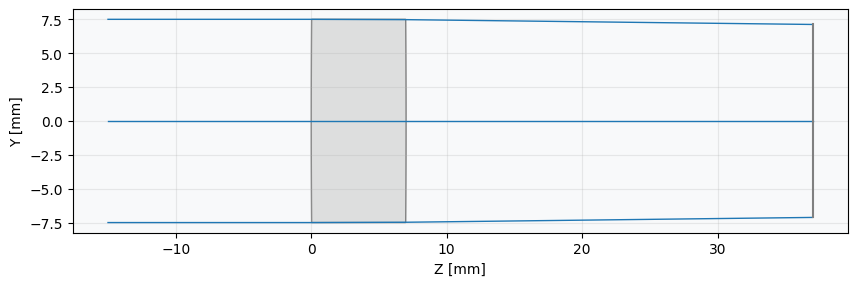

In [2]:
lens = optic.Optic()
lens.add_surface(index=0, thickness=be.inf)
lens.add_surface(index=1, thickness=7, radius=1000, material="N-SF11", is_stop=True)
lens.add_surface(index=2, thickness=30, radius=-1000)
lens.add_surface(index=3)
lens.set_aperture(aperture_type="EPD", value=15)
lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_wavelength(value=0.55, is_primary=True)
_ = lens.draw()

## Formulate the Optimization Problem

Here, we define the goal of our optimization. We specify what we want to minimize (the **operand**) and which parameters we can change (the **variables**).

In [3]:
problem = optimization.OptimizationProblem()
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0, "Hy": 0,
    "num_rays": 5,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}
problem.add_operand("rms_spot_size", target=0, weight=1, input_data=input_data)
problem.add_variable(lens, "radius", surface_number=1)
problem.add_variable(lens, "radius", surface_number=2)

## Define PyTorch module in Optiland

The `OpticalSystemModule` wraps our Optiland problem, making it compatible with PyTorch's ecosystem. This allows us to use standard PyTorch optimizers and training loops.

In [4]:
model = OpticalSystemModule(lens, problem)

## Define PyTorch Adam Optimizer and pass model parameters

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

## Optimize with PyTorch

This is a standard PyTorch training loop. In each step, we calculate the loss (RMS spot size), compute gradients using backpropagation, and update the lens radii with the optimizer.

In [6]:
# Store loss values for plotting
losses = []

# Run the optimization for 250 steps
for step in range(250):
    optimizer.zero_grad()       # Reset gradients from the previous step
    loss = model()              # Forward pass: calculate the loss (merit function value)
    loss.backward()             # Backward pass: compute gradients
    optimizer.step()            # Update lens radii based on gradients
    model.apply_bounds()        # (Optional) Apply any defined parameter constraints
    losses.append(loss.item())  # Record the loss for this step

In [7]:
# Display optimization problem information
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │             0.00722632 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.085 │   0.085 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤══════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │    Value │ Min. Bound   │ Max. Bound   │
╞════╪═════════════

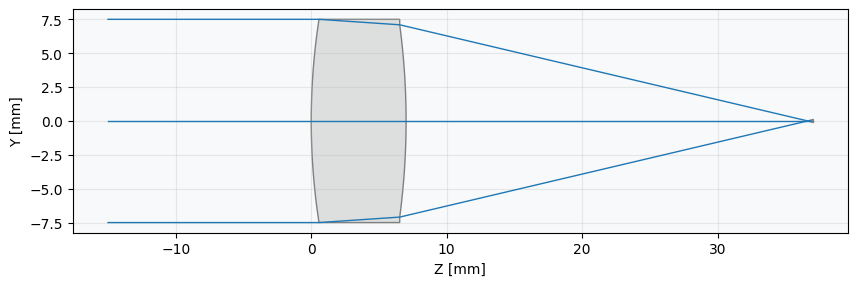

In [8]:
_ = lens.draw()

## Plot Losses

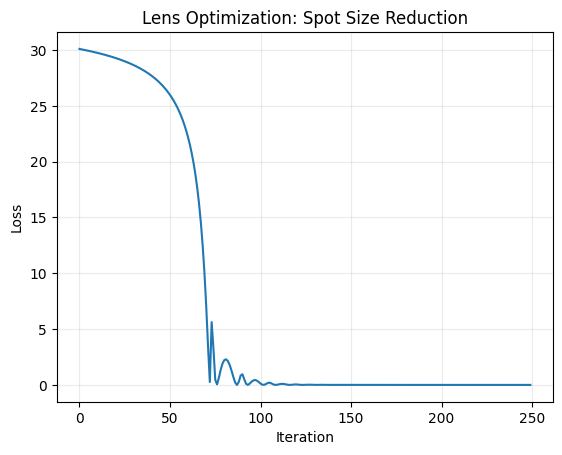

In [9]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Lens Optimization: Spot Size Reduction")
plt.grid(alpha=0.25)
plt.show()